<a href="https://colab.research.google.com/github/marcocaggioni/microrheology-test/blob/master/particle%20tracking%20microrheology%20-%20reading%20data%20from%20quilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install pims
!pip install trackpy
!pip install quilt

     |████████████████████████████████| 122kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/8f/9d/81/cca731559ef53bd55e6c73857ea63d342af2fd4137d5f644fb
Successfully built trackpy


In [3]:
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
from matplotlib.pyplot import *
import os
import glob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
from scipy import fftpack
from IPython.display import display
from PIL import Image
import pims
import scipy.optimize as optimization
import pandas as pd
import pymongo
import gridfs
import mimetypes

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1630208/45929032 bytes (3.5%)4669440/45929032 bytes (10.2%)8249344/45929032 bytes (18.0%)11837440/45929032 bytes (25.8%)15368192/45929032 bytes (33.5%)18915328/45929032 bytes (41.2%)22528000/45929032 bytes (49.0%)25968640/45929032 bytes (56.5%)29384704/45929032 bytes (64.0%)32923648/45929032 bytes (71.7%)36544512/45929032 bytes (79.6%)40026112/45929032 bytes (87.1%)

In [7]:
!quilt install marcocaggioni/microrheology

100% 78.7M/78.7M [00:01<00:00, 47.1MB/s]


# Example Particle tracking on video stored in MongoDB gridfs

In [0]:
from quilt.data.marcocaggioni import microrheology

The database is initally empty so we upload 

In [10]:
microrheology.n400nm_100dil_water_01umpix_100fps_short()

'/root/.local/share/QuiltCli/quilt_packages/objs/f16bc2ca999345c60fc560f0348d565515301a9c66215deeabdf9000f05b2d96'

In [0]:
info={'interval': 0.01,
 'filename': '400nm_100dil_water_01umpix_100fps_short.cin',
 'muperpix': 0.1,
 'tracer_radius': 0.0002,
 'temperature': 25,
 'operator': 'Marco'}

In [0]:
video=microrheology.n400nm_100dil_water_01umpix_100fps_short()

In [0]:
# Use pims to connect to the file-like object from the database
# we did slyghtly modify Cine.py to accept a GridOut cursor instead of filename string

pims_video=pims.Cine(video)

#Also store the info dictionary from the video object as an attribute of the pims object 
pims_video.info=info

Frame([[119, 118, 116, ..., 127, 125, 125],
       [108, 109, 113, ..., 119, 115, 117],
       [114, 116, 118, ..., 121, 122, 121],
       ...,
       [129, 128, 127, ..., 125, 126, 129],
       [124, 125, 125, ..., 124, 124, 122],
       [118, 117, 115, ..., 116, 117, 115]], dtype=uint8)
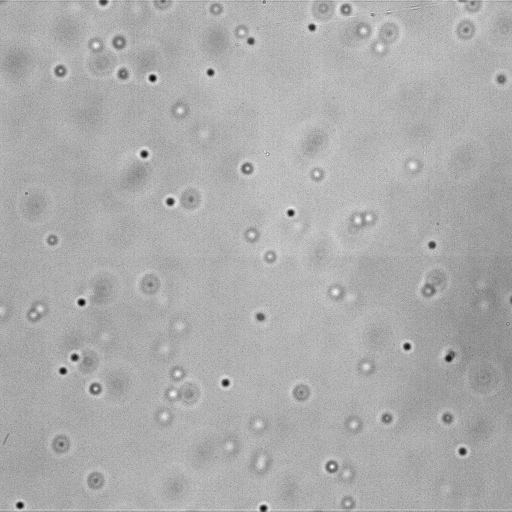

In [16]:
pims_video[2]

In [0]:
#Define simple video browser with ipywidgets



def browse_images_ptm(video):
    frames=len(video)
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    
    def view_image(framenum):
        pyplot.figure(figsize=(6,6))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    w.layout.height = '350px'
    return w



In [26]:
browse_images_ptm(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), layout=Layout(height='…

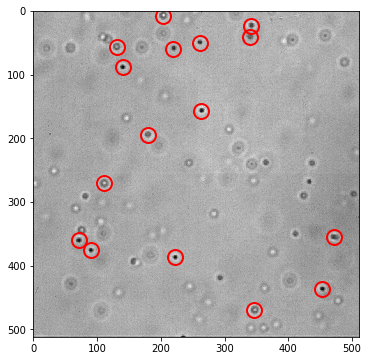

In [29]:
import trackpy as tp
fnum=100
pyplot.figure(figsize=(6,6))
fsingle = tp.locate(pims_video[fnum], 15, invert=True, minmass=1000)
tp.annotate(fsingle, pims_video[fnum])

In [30]:
f = tp.batch(pims_video, 15, minmass=1000, invert=True)

Frame 299: 12 features


In [0]:
pims_video.result_PT=f

In [0]:
def browse_images_tracked(video):
    frames=len(video)
    f=video.result_PT
    interval=video.info['interval']
    muperpix=video.info['muperpix']
    filename=video.info['filename']
    pixpermu=1/muperpix
    
    def view_image(framenum):
        pyplot.figure(figsize=(8,8))
        toplot=video[framenum]
        pyplot.title(str(' time: ' + str(framenum*interval) + ' s'))
        pyplot.imshow(toplot)
        pyplot.plot(f.x[f.frame==framenum],f.y[f.frame==framenum],'o')
        pyplot.set_cmap('gray')
        pyplot.axis('off')
        
    w=widgets.interactive(view_image, framenum=(0,frames-21))
    return w

In [37]:
browse_images_tracked(pims_video)

interactive(children=(IntSlider(value=139, description='framenum', max=279), Output()), _dom_classes=('widget-…

In [38]:
t = tp.link_df(f, 5, memory=3)

Frame 299: 12 trajectories present.


In [39]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,28.469664,311.026616,1146.375086,2.515911,0.035747,41.693258,20237.0,-1.421232,0,0
17,468.716586,332.114238,1259.136398,4.777972,0.102901,17.814392,21489.0,0.167593,0,1
16,415.926465,385.553937,1054.081374,4.383290,0.003760,16.866818,21155.0,0.238816,0,2
15,379.243692,224.376599,1096.532691,2.743972,0.044974,30.890914,20396.0,6.968164,0,3
14,369.852104,62.356948,1251.934836,2.429104,0.071772,48.326277,20621.0,0.745006,0,4


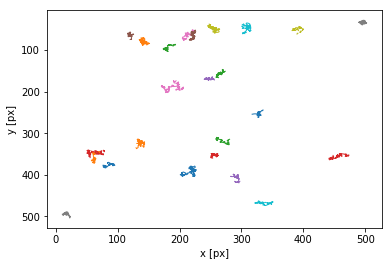

In [40]:
t1 = tp.filter_stubs(t, 50)
tp.plot_traj(t1)

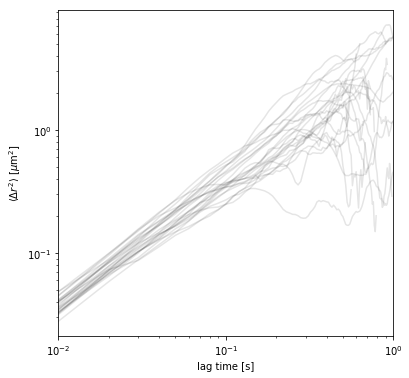

In [41]:
im = tp.imsd(t1, pims_video.info['muperpix'], pims_video.info['interval']**-1)
im.plot(loglog=True, style='k-', alpha=0.1, legend=False, figsize=(6,6))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]');

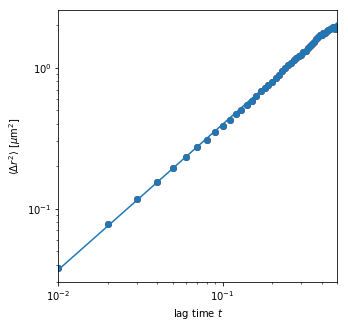

,n,A
msd,1.032386,4.278385


In [42]:
em = tp.emsd(t, pims_video.info['muperpix'], pims_video.info['interval']**-1,max_lagtime=50)
em.plot(loglog=True, style='ro', figsize=(5,5))
pyplot.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
pyplot.xlabel('lag time $t$')

result=tp.utils.fit_powerlaw(em)
result

For Newtonian liquids:
* $n=1$
* $A=4D$, where $D$ is the particles’ diffusivity.

$D$ is related to viscosity $\eta$, particle radius $a$, and temperature $T$ as:
$$D=\frac{kT}{6 \pi \eta a}$$

In [43]:
kb=1.380E-23
tempK=273+pims_video.info['temperature']

float(kb*tempK*4/(6*3.14*result.A*1e-12*pims_video.info['tracer_radius']))

1.0203862418772106e-06